# Dataset Loading


In [ ]:
import numpy
import pandas
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [ ]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12686090.89it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
train_imagenet_data = datasets.CelebA(
      root = 'data',
      split = "train",
      download = True,
      transform=ToTensor()
)

1443490838it [00:21, 68196287.47it/s] 
26721026it [00:00, 93501008.82it/s]
3424458it [00:00, 219661373.45it/s]
6082035it [00:00, 97173181.96it/s]
12156055it [00:00, 101493937.80it/s]
2836386it [00:00, 200899490.78it/s]


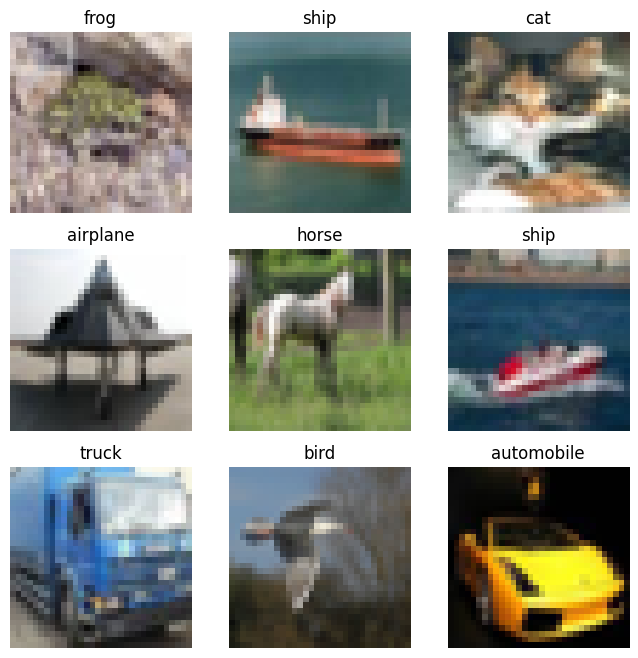

In [ ]:
Label_Names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    image, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    image = image.reshape(3,32,32)
    image = image.permute(1,2,0)
    plt.title(Label_Names[label])
    plt.imshow(image)
plt.show()

# DataLoaders

In [ ]:
import torchvision
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch.nn.utils.prune as prune
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision.utils as vutils
from torch.autograd import Variable

In [ ]:
def get_default_device():
  """pick GPU if available , else GPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data ,device):
  """Move tensor(s) to chosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    """Yield a batch of data after moving ot to device"""
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """Number of Batches"""
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
transform = torchvision.transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)),
      transforms.Resize(64)
  ])

batch_size = 64
trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
trainloader = DeviceDataLoader(trainloader, device)

testset = torchvision.datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DeviceDataLoader(testloader, device)

In [ ]:
def sample_images(dl):
  img_grid = None
  for x,y in dl:
    img_grid = make_grid(x.cpu(), nrows = 8)
    break
  plt.imshow(img_grid.permute(1, 2, 0))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

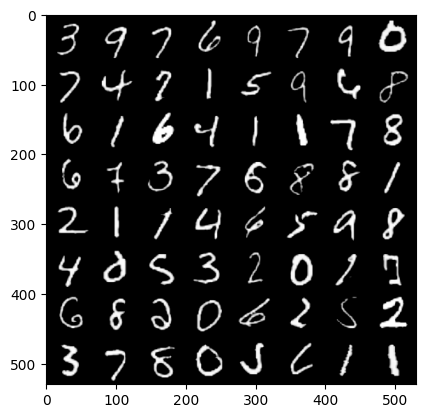

In [ ]:
sample_images(trainloader)

#Utils

In [ ]:
def get_subnet_layer( scores, bias_scores, k, scores_prune_threshold=-np.inf, bias_scores_prune_threshold=-np.inf):
  # Get the subnetwork by sorting the scores and using the top k%
  out = scores.clone()
  _, idx = scores.flatten().sort()
  j = int((1 - k) * scores.numel())

  # flat_out and out access the same memory.
  flat_out = out.flatten()
  flat_out[idx[:j]] = False
  flat_out[idx[j:]] = True

  bias_out = bias_scores.clone()
  _, idx = bias_scores.flatten().sort()
  j = int((1 - k) * bias_scores.numel())

  bias_flat_out = bias_out.flatten()
  bias_flat_out[idx[:j]] = 0
  bias_flat_out[idx[j:]] = 1

  return out, bias_out


In [ ]:
# mapping of individual layers to their respective scores
scores = {}

param_type_mapping = {}
for name, module in model.named_modules():
  if isinstance(module, nn.Conv2d):
    param_type_mapping[name] = "Conv2d"
  elif isinstance(module, nn.Linear):
    param_type_mapping[name] = "Linear"
  elif isinstance(module, nn.ConvTranspose2d):
    param_type_mapping[name] = "ConvT2d"


for name, module in model.named_parameters():
  layer_name = ".".join(name.rsplit(".")[:-1]) # in the form of layern.i.j.weight or bias
  module_type = ".".join(name.rsplit(".")[-1])
  if module_type =="weight":
    if param_type_mapping[layer_name] == "Conv2d" or param_type_mapping[layer_name] == "ConvT2d":
      scores[name] = nn.init.uniform_(torch.Tensor(module.size()), a=51.1, b=52.1)
    elif param_type_mapping[layer_name] == "Linear":
      scores[name] = nn.init.uniform_(torch.Tensor(module.size()), a=-0.1, b=0.1)
  elif module_type == "bias":
    scores[name] = nn.init.uniform_(torch.Tensor(module.size()), a=-1.0, b=1.0)


In [ ]:
param_type_mapping = {}
for name, module in model.named_modules():
  if isinstance(module, nn.Conv2d):
    param_type_mapping[name] = "Conv2d"
  elif isinstance(module, nn.Linear):
    param_type_mapping[name] = "Linear"
  elif isinstance(module, nn.ConvTranspose2d):
    param_type_mapping[name] = "ConvT2d"

# Model


In [ ]:
# logic for model pruning using BasePruningMethod
class EdgePop(prune.BasePruningMethod):
  PRUNING_TYPE = 'unstructured'
  def __init__(self):
    self.k = 0.1

  def compute_mask(self, t, default_mask):
    mask = t.clone()
    _, idx = t.flatten().sort()
    j = int((1 - self.k) * t.numel())

    # flat_out and out access the same memory.
    flat_out = mask.flatten()
    flat_out[idx[:j]] = False
    flat_out[idx[j:]] = True

    return mask

In [ ]:
# pruning step of individual layers according to edge pop algo
ep = EdgePop()
def prune_model(model, ep):
  for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
      try:
        if name+".weight" in scores.keys():
          ep.apply(module, name = 'weight', importance_scores = module.scores.abs())
        if name+".bias" in scores.keys():
          ep.apply(module, name = 'bias', importance_scores = module.bias_scores.abs())
      except:
        print(module)
    elif isinstance(module, nn.Linear):
      if name+".weight" in scores.keys():
        ep.apply(module, name = 'weight', importance_scores = module.scores.abs())
      if name+".bias" in scores.keys():
        ep.apply(module, name = 'bias', importance_scores = module.bias_scores.abs())


#Discriminator

In [ ]:
class DResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, use_BN = False, downsample=False):
        super(DResBlock, self).__init__()
        hidden_channels = in_channels
        self.downsample = downsample

        self.resblock = self.make_res_block(in_channels, out_channels, hidden_channels, use_BN, downsample)
        self.residual_connect = self.make_residual_connect(in_channels, out_channels)
    def make_res_block(self, in_channels, out_channels, hidden_channels, use_BN, downsample):
        model = []
        if use_BN:
            model += [nn.BatchNorm2d(in_channels)]

        model += [nn.ReLU()]
        model += [nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)]
        model += [nn.ReLU()]
        model += [nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)]
        if downsample:
            model += [nn.AvgPool2d(2)]
        return nn.Sequential(*model)
    def make_residual_connect(self, in_channels, out_channels):
        model = []
        model += [nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)]
        if self.downsample:
            model += [nn.AvgPool2d(2)]
            return nn.Sequential(*model)
        else:
            return nn.Sequential(*model)

    def forward(self, input):
        return self.resblock(input) + self.residual_connect(input)

class OptimizedBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OptimizedBlock, self).__init__()
        self.res_block = self.make_res_block(in_channels, out_channels)
        self.residual_connect = self.make_residual_connect(in_channels, out_channels)
    def make_res_block(self, in_channels, out_channels):
        model = []
        model += [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)]
        model += [nn.ReLU()]
        model += [nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)]
        model += [nn.AvgPool2d(2)]
        return nn.Sequential(*model)
    def make_residual_connect(self, in_channels, out_channels):
        model = []
        model += [nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)]
        model += [nn.AvgPool2d(2)]
        return nn.Sequential(*model)
    def forward(self, input):
        return self.res_block(input) + self.residual_connect(input)

class SNResDiscriminator(nn.Module):
    def __init__(self, ndf=64, ndlayers=4):
        super(SNResDiscriminator, self).__init__()
        self.res_d = self.make_model(ndf, ndlayers)
        self.fc = nn.Sequential(nn.Linear(ndf*16, 1), nn.Sigmoid())
    def make_model(self, ndf, ndlayers):
        model = []
        model += [OptimizedBlock(3, ndf)]
        tndf = ndf
        for i in range(ndlayers):
            model += [DResBlock(tndf, tndf*2, downsample=True)]
            tndf *= 2
        model += [nn.ReLU()]
        return nn.Sequential(*model)
    def forward(self, input):
        out = self.res_d(input)
        out = F.avg_pool2d(out, out.size(3), stride=1)
        out = out.view(-1, 1024)
        return self.fc(out)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class subConv(nn.Conv2d):
  def __init__(self, *args, **kwargs):
    super(subConv, self).__init__(*args, **kwargs)
    self.scores = nn.Parameter(torch.Tensor(self.weight.size()), requires_grad=True)
    if self.bias != None:
        self.bias_scores = nn.Parameter(torch.Tensor(self.bias.size()), requires_grad = True)
    else:
        self.bias_scores = nn.Parameter(torch.tensor(0.9))
    nn.init.uniform_(self.scores, a=-0.1, b=0.1)
    nn.init.uniform_(self.bias_scores, a=-1.0, b=1.0)
  def forward(self, x):
    x = F.conv2d(
            x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
    return x

class subLinear(nn.Linear):
  def __init__(self, *args, **kwargs):
    super(subLinear, self).__init__(*args, **kwargs)
    self.scores = nn.Parameter(torch.Tensor(self.weight.size()), requires_grad =True)

    if self.bias != None:
      self.bias_scores = nn.Parameter(torch.Tensor(self.bias.size()))
    else:
      self.bias_scores = nn.Parameter(torch.tensor(0.9))
    nn.init.uniform_(self.scores, a=-0.1, b=0.1)
    nn.init.uniform_(self.bias_scores, a=-1.0, b=1.0)

  def forward(self, x):
    x = F.Linear(
            x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
    return x

# Generator

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class GResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, upsample=False):
        super(GResBlock, self).__init__()
        #self.conv1 = SNConv2d(n_dim, n_out, kernel_size=3, stride=2)
        hidden_channels = in_channels
        self.upsample = upsample
        self.conv1 = subConv(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv2 = subConv(hidden_channels, out_channels, kernel_size=3, padding=1)
        self.conv_sc = subConv(in_channels, out_channels, kernel_size=1, padding=0)
        self.upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(hidden_channels)
        self.relu = nn.ReLU()
    def forward_residual_connect(self, input):
        out = self.conv_sc(input)
        if self.upsample:
             out = self.upsampling(out)
            #out = self.upconv2(out)
        return out
    def forward(self, input):
        out = self.relu(self.bn1(input))
        out = self.conv1(out)
        if self.upsample:
             out = self.upsampling(out)
             #out = self.upconv1(out)
        out = self.relu(self.bn2(out))
        out = self.conv2(out)
        out_res = self.forward_residual_connect(input)
        return out + out_res

class SNResGenerator(nn.Module):
    def __init__(self, ngf, z=128, nlayers=4):
        super(SNResGenerator, self).__init__()
        self.input_layer = nn.Linear(z, (4 ** 2) * ngf *16 )
        self.generator = self.make_model(ngf, nlayers)

    def make_model(self, ngf, nlayers):
        model = []
        tngf = ngf*16
        for i in range(nlayers):
            model += [GResBlock(tngf, tngf//2,  upsample=True)]
            tngf = tngf//2
        model += [nn.BatchNorm2d(ngf)]
        model += [nn.ReLU()]
        model += [subConv(ngf, 3, kernel_size=3, stride=1, padding=1)]
        model += [nn.Tanh()]
        return nn.Sequential(*model)

    def forward(self, z):
        out = self.input_layer(z)
        out = out.view(z.size(0), -1, 4, 4)
        out = self.generator(out)

        return out

# Training

In [ ]:
vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:02<00:00, 197MB/s]


In [ ]:
def getNetImageSizeAndNumFeats(net, verbose=False, image_size = 32, use_cuda = True, nc = 3):
    if use_cuda:
        y, layers = net(Variable(torch.randn(1,nc,image_size,image_size).cuda()))
    else:
        y, layers = net(Variable(torch.randn(1,nc,image_size,image_size)))


    layer_img_size = []
    layer_num_feats = []
    for L in reversed(layers):
        if len(L.size()) == 4:
            layer_img_size.append(L.size(2))
            layer_num_feats.append(L.size(1)*L.size(2)*L.size(3))
        elif len(L.size()) == 3:    # vit
            print('L size', L.shape)
            layer_img_size.append(1)
            layer_num_feats.append(L.size(1)*L.size(2))

        elif len(L.size()) == 2:
            layer_img_size.append(1)
            layer_num_feats.append(L.size(1))
        elif len(L.size()) == 1:
            layer_num_feats.append(L.size(0))
        else:
            assert 0, 'not sure how to handle this layer size '+L.size()

    return layer_img_size, layer_num_feats

In [ ]:
from collections import OrderedDict
class VGG(nn.Module):
  def __init__(self, num_classes =10):
    super().__init__()
    self.num_classes = num_classes
    self.vgg19 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)
    for param in self.vgg19.parameters():
      param.requires_grad = False
    self.linear = nn.Linear(1000, num_classes)
    self.Out = OrderedDict()

  def forward(self,x ):
    out = self.vgg19(x)
    out = self.linear(out)
    Out = []
    for k, v in self.Out.items():
        Out.append(v)
    Out.append(out)
    return out, Out

  def _get_hook(self, layer_num):
    Out = self.Out
    def myhook(module, _input, _out):
        Out[layer_num] = _out
    self.vgg19.features[layer_num].register_forward_hook(myhook)

In [ ]:
vgg = VGG(10).to(device)
summary(vgg, (3, 64, 64))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
for idx in range(len(vgg.vgg19.features)):
  if str(vgg.vgg19.features[idx])[0:4] == 'ReLU':
      vgg._get_hook(idx)
ImgSizeL, numFeatsL = getNetImageSizeAndNumFeats(vgg, image_size=64)

vgg.ImageSizePerLayer = np.array(ImgSizeL)
vgg.numberOfFeaturesPerLayer = np.array(numFeatsL)

In [ ]:
vgg.numberOfFeaturesPerLayer

array([    10,   8192,   8192,   8192,   8192,  32768,  32768,  32768,
        32768,  65536,  65536,  65536,  65536, 131072, 131072, 262144,
       262144])

In [ ]:
import os

os.listdir(".")

['.config', 'vgg19.pth', 'data', 'sample_data']

In [ ]:
optimizer = torch.optim.Adam(vgg.parameters(),lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
total_loss = 0
for epoch in range(50):
  total_loss = 0
  n = 0
  l = 0.0
  correct = 0
  for x, y in trainloader:
    optimizer.zero_grad()
    pred, _ = vgg(x.repeat(1,3,1,1))
    pred = nn.Softmax()(pred)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    n += len(y)
  with torch.no_grad():

    for x,y in testloader:
      preds, _ = vgg(x.repeat(1,3,1,1))
      preds = torch.argmax(preds, dim =1 )
      correct += torch.sum(preds==y).item()
      l += len(y)

  print(f"epoch {epoch} : loss ",total_loss/n, " accuracy : ",correct/l)

epoch 0 : loss  0.027649362577994663  accuracy :  0.699
epoch 1 : loss  0.027692537713050844  accuracy :  0.6998
epoch 2 : loss  0.027692064519723256  accuracy :  0.7007
epoch 3 : loss  0.027647284793853758  accuracy :  0.7
epoch 4 : loss  0.027677381885051727  accuracy :  0.6929
epoch 5 : loss  0.027745914606253304  accuracy :  0.6942
epoch 6 : loss  0.027687733777364096  accuracy :  0.6995
epoch 7 : loss  0.027575972960392634  accuracy :  0.6985
epoch 8 : loss  0.027592825293540953  accuracy :  0.694
epoch 9 : loss  0.027632015562057494  accuracy :  0.7027
epoch 10 : loss  0.02760387267867724  accuracy :  0.6907


KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad():
  l = 0.0
  correct = 0
  for x,y in testloader:
    preds, _ = vgg(x.repeat(1,3,1,1))
    preds = torch.argmax(preds, dim =1 )
    correct += torch.sum(preds==y).item()
    l += len(y)
  print("accuracy : ",correct/l)

accuracy :  0.6934


In [ ]:
try:
  os.mkdir("./models")
except:
  pass

torch.save(vgg.state_dict(), "./models/vgg199.pth")

In [ ]:
from torch.autograd import Variable
import time
from tqdm import tqdm
import os

def extractFeatures(batchOfData, detachOutput=False):
    # gets features from each layer of netEnc
    ftrs = []
    ftrsPerLayer = vgg(batchOfData)[1]
    numFeaturesForEachEncLayer = vgg.numberOfFeaturesPerLayer
    numLayersToFtrMatching = min(16, len(numFeaturesForEachEncLayer))
    for lId in range(1, numLayersToFtrMatching + 1):
        cLid = lId - 1  # gets features in forward order

        ftrsOfLayer = ftrsPerLayer[cLid].view(
            ftrsPerLayer[cLid].size()[0], -1)

        if detachOutput:
            ftrs.append(ftrsOfLayer.detach())
        else:
            ftrs.append(ftrsOfLayer)
    ftrs = torch.cat(ftrs, dim=1)
    return ftrs

def compute_real_features(dataloader, device, numExamplesProcessed):
    input_t = torch.FloatTensor(64, 3, 28, 28).to(device)
    if numExamplesProcessed is None:
        numExamplesProcessed = 0.0
    globalFtrMeanValues = []
    for i, data in enumerate(tqdm(dataloader), 1):
        real_cpu = data[0]      # img, target

        real_cpu = real_cpu.to(device)

        if real_cpu.shape[1] ==1:
            real_cpu = real_cpu.expand(
                real_cpu.shape[0], 3, real_cpu.shape[-1], real_cpu.shape[-1])

        input_t.resize_as_(real_cpu).copy_(real_cpu)
        realData = Variable(input_t)
        numExamplesProcessed += realData.size()[0]

        # extracts features for TRUE data
        allFtrsTrue = extractFeatures(realData, detachOutput=True)

        if len(globalFtrMeanValues) < 1:
            globalFtrMeanValues = torch.sum(allFtrsTrue, dim=0).detach()
            featureSqrdValues = torch.sum(allFtrsTrue** 2, dim=0).detach()
        else:
            globalFtrMeanValues += torch.sum(allFtrsTrue, dim=0).detach()
            featureSqrdValues += torch.sum(allFtrsTrue ** 2, dim=0).detach()

    return numExamplesProcessed, globalFtrMeanValues, featureSqrdValues

def computeReal( dataloader, device):
    numExamplesProcessed = 0.0
    numExamplesProcessed, globalFtrMeanValues, featureSqrdValues = compute_real_features(
                                                                    dataloader=dataloader,
                                                                    device=device,
                                                                    numExamplesProcessed=numExamplesProcessed)
    # variance = (SumSq - (Sum x Sum) / n) / (n - 1)
    globalFtrVarValues = (featureSqrdValues - (globalFtrMeanValues ** 2) / numExamplesProcessed) / (
                        numExamplesProcessed - 1)
    globalFtrMeanValues = globalFtrMeanValues / numExamplesProcessed
    return globalFtrMeanValues, globalFtrVarValues

In [ ]:
inception_model = torchvision.models.inception_v3(pretrained=True, transform_input=False).to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 32.6MB/s] 


In [ ]:
from scipy.linalg import sqrtm

def eval_score(real_images, fake_images):



    inception_model.eval()

    with torch.no_grad():
        real_features = inception_model(real_images).detach().cpu().numpy()
        mu1, cov1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)

        fake_features = inception_model(fake_images).detach().cpu().numpy()
        mu2, cov2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    # Calculate FID score
    diff = mu1 - mu2
    cov_sqrt, _ = sqrtm(cov1.dot(cov2), disp=False)
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    fid_score = diff.dot(diff) + np.trace(cov1 + cov2 - 2 * cov_sqrt)
    return fid_score

In [ ]:
def mmdtrain( netG, curNetEnc, netMean, netVar, optimizerG, optimizerMean, optimizerVar, traindataloader, path_dict, device):

    netG.train()
    #Initial settings
    # if opt.scheduler == "cos":
    schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerG, T_max=10, eta_min=0)
    schedulerMean = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerMean, T_max=10, eta_min=0)
    schedulerVar = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerVar, T_max=10, eta_min=0)
    # elif opt.scheduler == False:
    #     schedulerG = None
    #     schedulerMean = None
    #     schedulerVar = None
    # if (opt.scheduler != False) and opt.ckpt != None:
    #     loadmodel = torch.load(opt.ckpt, map_location = device)
    #     schedulerG.load_state_dict(loadmodel['schedulerG_state_dict'])
    #     schedulerMean.load_state_dict(loadmodel['schedulerMean_state_dict'])
    #     schedulerVar.load_state_dict(loadmodel['schedulerVar_state_dict'])
    #     opt.firstBatchId = loadmodel['optimizerVar_state_dict']['state'][0]['step']


    # if opt.netGType == "sngan":
    noise = torch.FloatTensor(64, 128).to(device)
    fixed_noise = Variable(torch.FloatTensor(min(64, 64), 128).normal_(0, 1).to(device))
    # else:
    #     noise = torch.FloatTensor(opt.batchSize, opt.nz, 1,1).to(device)
    #     fixed_noise = Variable(torch.FloatTensor(min(64, opt.batchSize), opt.nz, 1, 1).normal_(0, 1).to(device))
    avrgLossNetGMean = 0.0
    avrgLossNetGVar = 0.0
    avrgLossNetMean = 0.0
    avrgLossNetVar = 0.0
    # criterionL1Loss = nn.L1Loss().to(device)
    criterionL2Loss = nn.MSELoss().to(device)
    FID_list = []

    # Preporcessing for ImageNet
    # imageNetNormMinV, imageNetNormRangeV = Preprocessing_ImgNet(device)
    # Computing Real Dataset
    features_dict = 'sngan_19_64_28.tar'
    # if opt.ckpt != None:
    #     loadmodel = torch.load(opt.ckpt, map_location = device)
    #     globalFtrMeanValues, globalFtrVarValues = loadmodel['Mean'].to(device), loadmodel['Var'].to(device)
    # else:
    if os.path.isfile("./features/"+features_dict) == True:
        ftr_check = torch.load("./features/"+features_dict, map_location = device)
        globalFtrMeanValues, globalFtrVarValues = ftr_check['Mean'].to(device), ftr_check['Var'].to(device)
    else:
        globalFtrMeanValues, globalFtrVarValues = computeReal(traindataloader, device)
        torch.save({'Mean':globalFtrMeanValues, 'Var':globalFtrVarValues}, "./features/"+features_dict)

    # Training start
    start_time = time.time()

    for iterId in range(0, len(traindataloader)):
        curNetEnc.zero_grad()
        netG.zero_grad()
        netMean.zero_grad()
        netVar.zero_grad()
        # if (opt.algorithm == "gm") and (iterId % opt.project_freq == 0) and not opt.differentiate_clamp:
        #     for name, params in netG.named_parameters():
        #         if "score" in name:
        #             scores = params
        #             with torch.no_grad():
        #                 scores.data = torch.clamp(scores.data, 0.0, 1.0)
        # creates noise
        # if opt.netGType == "sngan":
        noise.resize_(64, 128).normal_(0, 1.0)
        noisev = Variable(noise)
        # else:
        #     noise.resize_(opt.batchSize, int(opt.nz), 1, 1).normal_(0, 1.0)
        #     noisev = Variable(noise)
        fakeData = netG(noisev)


        # normalize part
        # if fakeData.shape[1] == 1: #gray img
        fakeData = fakeData.expand(fakeData.shape[0], 3, fakeData.shape[-1], fakeData.shape[-1])
        # elif fakeData.shape[1] == 3: #color img
        #     fakeData = (((fakeData + 1) * imageNetNormRangeV) / 2) + imageNetNormMinV

        ftrsFake = [extractFeatures( fakeData, detachOutput=False)] #featureextract

        # updates Adam moving average of mean differences

        ftrsMeanFakeData = [torch.mean(ftrsFakeData, 0) for ftrsFakeData in ftrsFake]#evaluate mean
        diffFtrMeanTrueFake = globalFtrMeanValues.detach() - ftrsMeanFakeData[0].detach()

        lossNetMean = criterionL2Loss(netMean.weight, diffFtrMeanTrueFake.detach().view(1, -1))

        lossNetMean.backward()
        avrgLossNetMean += lossNetMean.item()
        optimizerMean.step()
        # if opt.scheduler != False:
        schedulerMean.step()


        # updates moving average of variance differences
        ftrsVarFakeData = [torch.var(ftrsFakeData, 0) for ftrsFakeData in ftrsFake]
        diffFtrVarTrueFake = globalFtrVarValues.detach() - ftrsVarFakeData[0].detach()

        lossNetVar = criterionL2Loss(netVar.weight, diffFtrVarTrueFake.detach().view(1, -1))

        lossNetVar.backward()
        avrgLossNetVar += lossNetVar.item()
        optimizerVar.step()
        # if opt.scheduler != False:
        schedulerVar.step()


        # updates generator
        meanDiffXTrueMean = netMean(globalFtrMeanValues.view(1, -1)).detach()
        meanDiffXFakeMean = netMean(ftrsMeanFakeData[0].view(1, -1))

        varDiffXTrueVar = netVar(globalFtrVarValues.view(1, -1)).detach()
        varDiffXFakeVar = netVar(ftrsVarFakeData[0].view(1, -1))



        lossNetGMean = (meanDiffXTrueMean - meanDiffXFakeMean)
        avrgLossNetGMean += lossNetGMean.item()

        lossNetGVar = (varDiffXTrueVar - varDiffXFakeVar)
        avrgLossNetGVar += lossNetGVar.item()

        regularization_loss = torch.tensor(0).to(device)
        # if opt.algorithm == "gm":
        #     regularization_loss = get_regularization_loss(netG, regularizer = opt.regularization, lmbda = opt.lmbda, alpha = opt.alpha, alpha_prime = opt.alpha_prime, device = device)
        #     regularization_loss.to(device)

        lossNetG = lossNetGMean + lossNetGVar + regularization_loss


        lossNetG.backward()
        optimizerG.step()
        # if opt.scheduler != False:
        schedulerG.step()
        # if (opt.algorithm == "gm") and ((iterId) % (opt.project_freq*opt.freezing_period) == 0) and (iterId != 0):
        # prune(netG, update_scores = True)
        # if opt.algorithm == "global_ep":
        # prune(netG, update_thresholds_only = True)
        # reset_flag(netG)




        # if (iterId) % opt.numBatchsToValid == 0:
        #     log.info('[{%d}/{%d}] Loss_Gz: %.6f Loss_GzVar: %.6f Loss_vMean: %.6f Loss_vVar: %.6f' %
        #             (iterId, opt.niter,
        #             avrgLossNetGMean / opt.numBatchsToValid, avrgLossNetGVar / opt.numBatchsToValid,
        #             avrgLossNetMean / opt.numBatchsToValid, avrgLossNetVar / opt.numBatchsToValid))
        #     if opt.algorithm == "gm":
        #         cp_model = round_model(netG, 0.5, True, 0, None)
        #         print("sparsity: ", get_model_sparsity(cp_model))



            # os.sys.stdout.flush()

        avrgLossNetGMean = 0.0
        avrgLossNetMean = 0.0
        avrgLossNetGVar = 0.0
        avrgLossNetVar = 0.0



        if (iterId + 1) % 100 == 0:
            netG.eval()
            iterID_FID = eval_score(path_dict, netG, iterId, device)
            FID_list.append(iterID_FID)
            print("Best performance(FID, idx): ", min(FID_list), 100 * (FID_list.index(min(FID_list))+1))
            if min(FID_list) == iterID_FID:
              prune_model(netG, ep)

            fileSuffix = iterId+1 / 100

            fake = netG(fixed_noise).detach()
            vutils.save_image(fake.data[:min(64, 64)], '%s/%s/%s/fake_samples_iterId_%04d.png' % (
                                                'results', "sngan_imp_0.1",  'images', fileSuffix), nrow = int(8),
                                                normalize=True, range=None)
            del fake

            fake_va = netG(noisev).detach()
            vutils.save_image(fake_va.data[:min(64, 64)], '%s/%s/%s/fake_samples_iterId_%04d.png' % (
                                                'results', 'sngan_imp_0.1',  'images_va', fileSuffix), nrow = int(8),
                                                normalize=True, range=None)
            del fake_va


            netG.train()




        # saving models
        if (iterId + 1) % 200 == 0:
            # if opt.algorithm in ["ep", "global_ep"]:
            prune_model(netG, ep)
                # saveModel(opt, netG, netMean, netVar, curNetEnc, optimizerG, optimizerMean, optimizerVar, globalFtrMeanValues, globalFtrVarValues, schedulerG, schedulerMean, schedulerVar, suffix="newest")
                # layer_sparsity(netG)
                # reset_flag(netG)
            # else:
            #     saveModel(opt, netG, netMean, netVar, curNetEnc, optimizerG, optimizerMean, optimizerVar, globalFtrMeanValues, globalFtrVarValues, schedulerG, schedulerMean, schedulerVar, suffix="newest")



    print('#'*40)
    print('Finish Training')
    print("Running Time: ", time.time() - start_time)
    print('#'*40)
    print("Best performance(FID, idx): ", min(FID_list), 100 * (FID_list.index(min(FID_list))+1))






In [ ]:
netG = SNResGenerator(256)
netG.to(device)

SNResGenerator(
  (input_layer): Linear(in_features=128, out_features=65536, bias=True)
  (generator): Sequential(
    (0): GResBlock(
      (conv1): subConv(4096, 4096, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): subConv(4096, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_sc): subConv(4096, 2048, kernel_size=(1, 1), stride=(1, 1))
      (upsampling): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
      (bn1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): GResBlock(
      (conv1): subConv(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): subConv(2048, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_sc): subConv(2048, 1024, kernel_size=(1, 1), stride=(1, 1))
      (upsampling): UpsamplingBilinear2d(scale_factor=2.0, mode=

In [ ]:
vgg.load_state_dict(torch.load("./models/vgg199.pth", map_location=device))

<All keys matched successfully>

In [ ]:
def createMovingNet( curNetEnc, device):
    numFeaturesInEnc = 0
    numFeaturesForEachEncLayer = curNetEnc.numberOfFeaturesPerLayer
    numLayersToFtrMatching = min(16, len(numFeaturesForEachEncLayer))
    numFeaturesInEnc += sum(numFeaturesForEachEncLayer[-numLayersToFtrMatching:])
    netMean = nn.Linear(numFeaturesInEnc, 1, bias=False)
    netVar = nn.Linear(numFeaturesInEnc, 1, bias=False)
    netMean.to(device)
    netVar.to(device)

    return netMean, netVar

In [ ]:
netMean, netVar = createMovingNet(vgg, device)

In [ ]:
import torch.optim as optim

In [ ]:
optimizerG = optim.Adam(netG.parameters(), lr=0.005, betas=(0.5, 0.999))
optimizerMean = optim.Adam(netMean.parameters(), lr=0.005, betas=(0.5, 0.999))
optimizerVar = optim.Adam(netVar.parameters(), lr=0.005, betas=(0.5, 0.999))

In [ ]:
for x, y in trainloader:
  save_image(x